# 사물 이미지 분류 경진대회

## 데이터 불러오기

In [1]:
import os
import pandas as pd
import warnings
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import torch
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [2]:
## 데이터를 불러올 함수를 정의
def load_CIFAR10(path, train=True):
    '''
    If train then
        path -> folder1, folder2, ..., folder10
        folder1 -> img1, img2, ..., img5000
        ...
        folder10 -> img1, img2, ..., img5000
        
    If test then
        path -> img1, img2, ..., img5000
    '''
    from tqdm import tqdm
    path = path ## 이미지 파일들이 담겨있는 폴더들이 담겨있는 파일 경로
    images = [] ## 이미지 리스트
    labels = [] ## 라벨 리스트
    
    ## train
    if train:
        for foldername in tqdm(os.listdir(path)): ## 이미지 파일들이 담겨있는 폴더 이름(=라벨)
            img_path = path + foldername + '/'
            for img in os.listdir(img_path):  ## 폴더에 담겨있는 이미지들
                an_img = Image.open(img_path + img)  ## 이미지를 불러온다
                img_array = np.array(an_img)  ## 이미지를 넘파이 어레이로 변경한다
                images.append(img_array)      ## 이미지 리스트에 넘파이 어레이로 된 이미지를 추가한다
                label = foldername            ## 라벨을 가져온다
                labels.append(label)          ## 라벨 리스트에 라벨을 추가한다
                
        return images, labels ## 이미지와 라벨을 반환
                
    ## test
    for img in tqdm(os.listdir(path)):
        an_img = Image.open(path + img)  
        img_array = np.array(an_img)  
        images.append(img_array)               
        
    return images ## 이미지를 반환(test는 라벨이 없다)

In [3]:
file_path = 'C:/Users/Jaesu/Dataset/CIFAR10_dataset/'

In [4]:
train_file_path = file_path + 'train/'
test_file_path = file_path + 'test/'

In [6]:
train_images, train_labels = load_CIFAR10(path=train_file_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:37<00:00, 45.78s/it]


In [5]:
test_images = load_CIFAR10(path=test_file_path, train=False)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:56<00:00, 85.59it/s]


`-` 신기한게 처음에 이미지 불러올 땐 6분 걸렸는데 다시 불러오니 22초 걸림

`-` 라벨 인코딩을 해주자

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

In [9]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
train_labels = train_labels.reshape(-1)
train_labels = torch.Tensor(train_labels).type(torch.LongTensor) ## 라벨은 Tensor

In [10]:
train_images.shape, train_labels.shape, test_images.shape

((50000, 32, 32, 3), torch.Size([50000]), (10000, 32, 32, 3))

## 간단한 EDA

`-` 무작위로 이미지를 뽑아 시각화

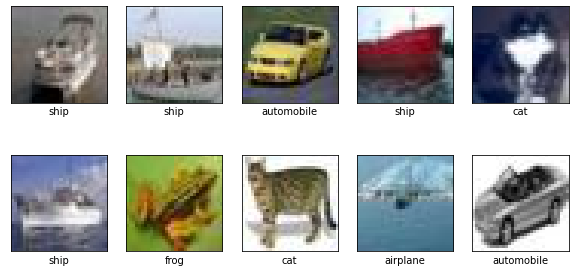

In [11]:
plt.figure(figsize=[10, 5])
for i in range(10):
    import random
    num = random.randint(0, 50000)
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(le.inverse_transform([train_labels[num].item()]).item())
    plt.imshow(train_images[num])
plt.show()

`-` 라벨 빈도수 확인

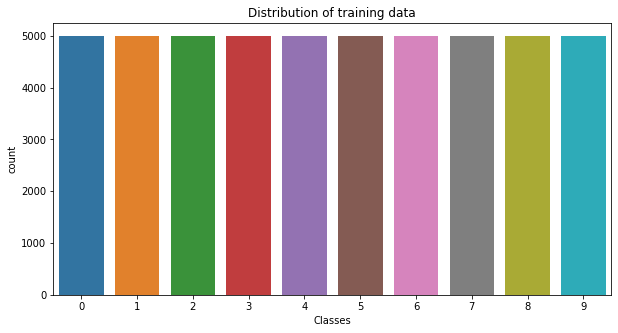

In [12]:
plt.figure(figsize=[10,5])
sns.countplot(np.array(train_labels))
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()

## Dataset 준비

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

`-` RGB 각각 표준화

In [14]:
RGB_MEAN = [np.mean((train_images[...,i] / 255)) for i in range(3)] ## 255로 나눈후 RGB 각각의 평균
RGB_STD = [np.std(train_images[...,i] / 255) for i in range(3)]  ## 255로 나눈후 RGB 각각의 표준편차

`-` 데이터 변환 방식 정의

In [32]:
## 데이터 변환 방식을 정의(Agumentation)
def get_transform(train=True):
    trans = transforms.Compose([
        transforms.ToTensor(), ## 0~255 -> 0~1
        transforms.Normalize(RGB_MEAN, RGB_STD) ## 평균을 0, 표준편차를 1로 만듦
    ])
    
    if train:
        trans = transforms.Compose([
            transforms.ToPILImage(), ## numpy array를 PIL이미지로 바꾸고 이미지를 변형시킨다 ## 변형은 PIL이미지 타입일 때 가능
            #transforms.RandomResizedCrop(size=32, scale=(0.6, 1.0)), # 0.6~1.0 비율 영역을 무작위로 잘라내기
            transforms.RandomHorizontalFlip(p=0.5), ## 50%의 확률로 수평으로 뒤집음
            transforms.RandomRotation(degrees=20), ## 무작위로 -20~20도 회전
            transforms.ToTensor(), ## PIL이미지를 다시 텐서로 변환하고 0~1로 정규화
            transforms.Normalize(RGB_MEAN, RGB_STD) ## 평균을 0, 표준편차를 1로 만듦
        ])

    return trans ## 데이터 변환 방식을 반환

`-` 데이터셋 정의

In [16]:
class CustomDataset(Dataset):
    def __init__(self, X: np.array, labels=None, transform=None, target_transform=None):
        self.X = X  ## 넘파이 어레이로 변환된 이미지
        self.labels = labels  ## 라벨
        self.transform = transform  ## X 변환방법
        self.target_transform = target_transform ## 라벨 변환방법
    
    def __getitem__(self, idx):
        numpy_img = self.X[idx]
        if self.transform is not None: 
            transformed_img = self.transform(numpy_img) 
            
        if self.labels is not None:
            label = self.labels[idx]
            if self.target_transform:
                label = self.target_transform(label)             
            return transformed_img, label  ## train   
        
        return transformed_img  ## test
    
    def __len__(self):
        return len(self.X) ## 데이터 개수 반환

In [17]:
transform_train = get_transform() ## train
transform_test = get_transform(train=False) ## test

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=22)
X_test = copy.deepcopy(test_images)

In [19]:
print('X_train 크기:', X_train.shape)
print('X_valid 크기:', X_valid.shape)
print('X_test  크기:', X_test.shape)

X_train 크기: (40000, 32, 32, 3)
X_valid 크기: (10000, 32, 32, 3)
X_test  크기: (10000, 32, 32, 3)


## 모델 설계

`-` 학습은 gpu없으면 너무 오래걸려서 colab에서 해야됨

`-` 아래는 모델이 잘 돌아가는지 확인용으로 작성함

In [29]:
#nn.init.xavier_normal_?

In [36]:
w = torch.empty(3, 3)

In [37]:
print(w)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [38]:
nn.init.xavier_normal_(w) ## 모델의 가중치를 가우시안 분포를 사용하여 초기화
print(w)

tensor([[-0.2961, -0.6533,  0.5028],
        [ 0.4814, -0.0267,  0.2600],
        [-0.4015, -0.0679, -0.5427]])


In [20]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = models.resnet18(pretrained=False) ## Resnet18 아키텍쳐사용
        self.drop = nn.Dropout(0.25)
        self.fc = nn.Linear(1000, 10) ## resnet18의 최종 output차원은 1000
        nn.init.xavier_normal_(self.fc.weight) ## 모델의 가중치 초기화 ---> 매우 중요(안하면 성능 매우 많이 떨어짐) 
        
    def forward(self, x):
        x = self.model(x)
        x = self.drop(x)
        x = self.fc(x)
        return x

In [21]:
## 랜덤 시드 고정
torch.manual_seed(22)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
learning_rate = 0.001
epochs = 1 ## test 용도, 나중에 할 땐 10으로 변경
batch_size = 100

`-` train 데이터셋과 데이터로더

In [24]:
train_dataset = CustomDataset(X=X_train, labels=y_train, transform=transform_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

`-` valid 데이터셋과 데이터로더

In [25]:
valid_dataset = CustomDataset(X=X_valid, labels=y_valid, transform=transform_train)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [26]:
total_batch = len(train_dataloader)
print(f'총 배치의 수 : {total_batch}')

총 배치의 수 : 400


In [27]:
## 모델 정의
net = CustomModel().to(device)

In [28]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)   ## 비용 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) ## 옵티마이저에 최적화할 파라미터와 학습률 전달

`-` 이제 모델을 훈련시키자

In [29]:
net.train() ## 훈련모드
for epoch in range(epochs):
    avg_loss = 0 ## 평균 loss

    for X, y in tqdm(train_dataloader): # 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X = X.to(device)
        y = y.to(device) ## shape를 2d에서 1d로 맞춰주고 type을 float32에서 int64로 바꿔줌

        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = net(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y) ## 오차를 계산
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트

        avg_loss += (loss / total_batch)

    print('[Epoch: {:>4}] loss = {:>.9}'.format(epoch + 1, avg_loss))

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [11:18<00:00,  1.70s/it]

[Epoch:    1] loss = 2.01297808


In [30]:
## accuracy 계산
def accuracy(true, pred):
    return sum(true == pred) / len(true)

In [31]:
net.eval() ## 평가모드
valid_loss = [] 
acc_list = []

with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
    for X, y in tqdm(valid_dataloader):
        X = X.to(device)
        y = y.to(device)
        yhat = net(X)
        loss = loss_fn(yhat,y)
        acc = accuracy(y.detach().cpu().numpy(), yhat.detach().cpu().numpy().argmax(-1))                                                         
        valid_loss.append(loss)
        acc_list.append(acc)
            
print(f'Mean Valid Loss : {np.mean(valid_loss):>8f}') ## 평가 루프 종료시 평균 loss를 출력
print(f'Mean Valid accuracy : {np.mean(acc_list):>8f}') ## 평가 루프 종료시 accuracy를 출력

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]

Mean Valid Loss : 2.025927
Mean Valid accuracy : 0.360600


## test 예측

In [39]:
test_dataset = CustomDataset(X=X_test, transform=transform_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
preds = None

for X in tqdm(test_dataloader): 
    X = X.to(device)
    yhat = net(X)
    
    pred = yhat.detach().cpu().numpy().argmax(-1)
    if preds is None:
        preds = pred
    else:
        preds = np.concatenate([preds, pred])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.16it/s]


In [225]:
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CIFAR10/sample_submission.csv')

In [235]:
predictions = le.inverse_transform(preds)

In [237]:
submission['target'] = predictions

In [239]:
submission.head()

,id,target
0,0000.jpg,frog
1,0001.jpg,cat
2,0002.jpg,truck
3,0003.jpg,airplane
4,0004.jpg,deer


In [238]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/CIFAR10/submission.csv', index=False)

`-` 점수가 이상하게 나왔는데 test 데이터셋을 불러올 때 순서를 지키지 않아서 그런거였다